## Modified script from Yoona to crop individual cores

We want to crop the image of each core so we can align it with the H&E.

Pipeline overview:
1) Associate each cell with a core using the coreograph outputs (This should be done before running this script)
2) Use the assigned core information to get the x and y coordinates of the core (this means we get the four corners of a box around the cell)
3) Translate the coordinates built from cells to the coordinates of the high-res dapi image
4) Save these coordinates to a dataframe so we can locate any core for future alignment

In [47]:
import SimpleITK as sitk
from skimage import filters

import pyvips
# from skimage.transform import resize, rescale
import PIL
from PIL import Image
import imutils
from scipy import ndimage
from scipy.ndimage import shift
from skimage.transform import rescale

import cv2

from glob import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc

import time
import os
import pathlib
from pathlib import Path
import warnings
from scipy.signal import fftconvolve

import tifffile

# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib as mpl
# import matplotlib.pyplot as plt
# import matplotlib.colors
mpl.rcParams['pdf.fonttype'] = 42

from scipy.signal import find_peaks
sc._settings.settings._vector_friendly=True

In [48]:
# Read in the anndata with cores assigned
adata = sc.read_h5ad("/common/lamt2/HPV/data/xenium/adata/adata_coreograph.h5ad")

/common/lamt2/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [65]:
# Get a list of all the slides
slides = sorted(adata.obs['slide'].unique())
# use slicing to select only specific slides
slides = slides[2:3]
slides

['20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060354__Region_1__20250224__233922']

In [63]:
# Parameters for the tiff image
LEVEL = 4  # Which layer (resolution) to pick
pix_size = 3.4 # Pixel to micrometer conversion (1 pixel = 3.4 um)
padding = 80 # Number of pixels to pad the edges of the cropping
dir_out = "/common/lamt2/HPV/data/xenium/alignment"

In [ ]:
# Function to crop all slides/cores in a data set
# Can input a list of slide id's to crop only those slides
def cropAll(adata, df_idx, slides = None, padding = 80, saveimg = True):
    # If no slides are provided, loop over all slides
    if slides is None:
        slides = adata.obs['slide'].unique()
    for s in slides: # Loop over slides:
        f_morphology = f'/common/knottsilab/xenium/hpv/{s}/morphology_focus/morphology_focus_0000.ome.tif'
        img_mip = tifffile.imread(f_morphology, is_ome = False, level = LEVEL) # This converts the tiff file to an array of pixels
            
        xy = adata.obs.loc[adata.obs['slide'] == s, ['x_centroid', 'y_centroid', 'core']] # Get the x-y coordinates of cells on the current slide
        xy[['x_centroid', 'y_centroid']] = xy[['x_centroid', 'y_centroid']]/pix_size # Convert the x-y coordinates from um to pixels
        cores = sorted(xy[xy['core'] > 0]['core'].unique()) # Get a list of all cores on the slide
        
        for c in cores: # Loop over cores
            
            x0 = max(0, int(xy[xy['core'] == c]['x_centroid'].min() - padding)) # Leftmost x-value for cells in the core - padding (must be > 0)
            x1 = min(img_mip.shape[1], int(xy[xy['core'] == c]['x_centroid'].max() + padding)) # Rightmost x-value + padding (must be < right edge of slide)
            
            y0 = max(0, int(xy[xy['core'] == c]['y_centroid'].min() - padding)) # Lowest y-value for cells in the core - padding
            y1 = min(img_mip.shape[0], int(xy[xy['core'] == c]['y_centroid'].max() + padding)) # Highest y-value for cells in the core + padding
            
            plt.imshow(img_mip[y0:y1, x0:x1], vmax = 500)
            plt.title(f'{s.split('/')[-1]} - {c}')
            plt.show() # Show the current cropping
            
            # Now we check to make sure the image is okay
            # We do this because features can appear on the dapi/HE that are useful for alignment, but sometimes the cells are not seen in the ST data
            ispass = 'n'
            while ispass != 'y':
                ispass = input('Is pass? [y]/n/quit') or 'y'
                if ispass == 'quit':
                    return df_idx
                if ispass != 'y':
                    newidx = input(f'New coords (current = {x0}, {str(img_mip.shape[1])+"*" if x1 >= img_mip.shape[1] else x1}, {y0}, {str(img_mip.shape[0])+"*" if y1 >= img_mip.shape[0] else y1}): ') or f'{x0}, {x1}, {y0}, {y1}'
                    x0, x1, y0, y1 = [int(a) for a in newidx.split(',')]
                    x0 = max(x0, 0)
                    y0 = max(y0, 0)
                    x1 = min(x1, img_mip.shape[1])
                    y1 = min(y1, img_mip.shape[0])
                    plt.imshow(img_mip[y0:y1, x0:x1], vmax = 500)
                    plt.title(f'{s.split('/')[-1]} - {c}')
                    plt.show()

                    
            # Once we are happy with the cropping, we save the coordinates to the dataframe
            if len(df_idx) == 0 or f'{s}___{c}' not in df_idx.index:
                img_idx = pd.DataFrame({'x0': x0, 'x1': x1, 'y0': y0, 'y1': y1, 'slide': s, 'core': c}, index = [f'{s}___{c}'])
                df_idx = pd.concat([df_idx, img_idx])
            else:
                df_idx.loc[f'{s}___{c}'] = {'x0': x0, 'x1': x1, 'y0': y0, 'y1': y1, 'slide': s, 'core': c}
            if saveimg:
                plt.savefig(f'/common/lamt2/HPV/data/xenium/alignment/cropped_{s.split('/')[-1]}___{c}.png')
            print(f'{s}___{c} -- done')
    return df_idx

In [ ]:
# If any specific cores need to be redone, use this function instead of redoing every slide
def recrop(batch_idx, adata, df_idx, padding = 80, saveimg = None):
    s = batch_idx.split('___')[0]
    c = int(batch_idx.split('___')[1])
    f_morphology = f'/common/knottsilab/xenium/hpv/{s}/morphology_focus/morphology_focus_0000.ome.tif'
    img_mip = tifffile.imread(f_morphology, is_ome = False, level = LEVEL)
        
    xy = adata.obs.loc[(adata.obs['slide'] == s) & (adata.obs['core'] == c), ['x_centroid', 'y_centroid']]
    xy[['x_centroid', 'y_centroid']] = xy[['x_centroid', 'y_centroid']]/pix_size
    
    x0 = max(0, int(xy['x_centroid'].min() - padding))
    x1 = min(img_mip.shape[1], int(xy['x_centroid'].max() + padding))
    
    y0 = max(0, int(xy['y_centroid'].min() - padding))
    y1 = min(img_mip.shape[0], int(xy['y_centroid'].max() + padding))
    
    plt.imshow(img_mip[y0:y1, x0:x1], vmax = 500)
    plt.title(f'{s.split('/')[-1]} - {c}')
    plt.show()
    
    ispass = 'n'
    while ispass != 'y':
        ispass = input('Is pass? [y]/n/quit') or 'y'
        if ispass == 'quit':
            return df_idx
        if ispass != 'y':
            newidx = input(f'New coords (current = {x0}, {str(img_mip.shape[1])+"*" if x1 >= img_mip.shape[1] else x1}, {y0}, {str(img_mip.shape[0])+"*" if y1 >= img_mip.shape[0] else y1}): ') or f'{x0}, {x1}, {y0}, {y1}'
            x0, x1, y0, y1 = [int(a) for a in newidx.split(',')]
            x0 = max(x0, 0)
            y0 = max(y0, 0)
            x1 = min(x1, img_mip.shape[1])
            y1 = min(y1, img_mip.shape[0])
            plt.imshow(img_mip[y0:y1, x0:x1], vmax = 500)
            plt.title(f'{s.split('/')[-1]} - {c}')
            plt.show()
            
    if len(df_idx) == 0:
        img_idx = pd.DataFrame({'x0': x0, 'x1': x1, 'y0': y0, 'y1': y1, 'slide': s, 'core': c}, index = [f'{s}___{c}'])
        df_idx = pd.concat([df_idx, img_idx])
    elif f'{s}___{c}' not in df_idx.index:
        img_idx = pd.DataFrame({'x0': x0, 'x1': x1, 'y0': y0, 'y1': y1, 'slide': s, 'core': c}, index = [f'{s}___{c}'])
        df_idx = pd.concat([df_idx, img_idx])
    else:
        df_idx.loc[f'{s}___{c}'] = {'x0': x0, 'x1': x1, 'y0': y0, 'y1': y1, 'slide': s, 'core': c}
    if saveimg:
        plt.savefig(f'{saveimg}/cropped_{s.split('/')[-1]}___{c}.png')
    print(f'{s}___{c} -- done')
    return df_idx

In [ ]:
# Make the initial dataframe
df_idx = pd.DataFrame(columns = ['x0', 'x1', 'y0', 'y1', 'slide', 'core'])
# How to use the cropAll function:
# 1) Slide image will pop up along with a "Is pass?" prompt.
#       If good, click enter (or type 'y' and hit enter)
# 2) If not, another prompt with pop up asking for the new cropping
#       The current coordinates will be provided for reference. If a coordinate has * next to it, the boarder is at the edge of the slide and cannot be adjusted.
#       Type the new coordinates (formatted as x0, x1, y0, y1) and press enter
#       For example, if the coordinates clip the data on the right edge, we need to increase x1
# 3) If you want to exit, type 'quit' in response to the "Is pass?" prompt
df_idx = cropAll(adata, df_idx, slides = slides, saveimg = dir_out)

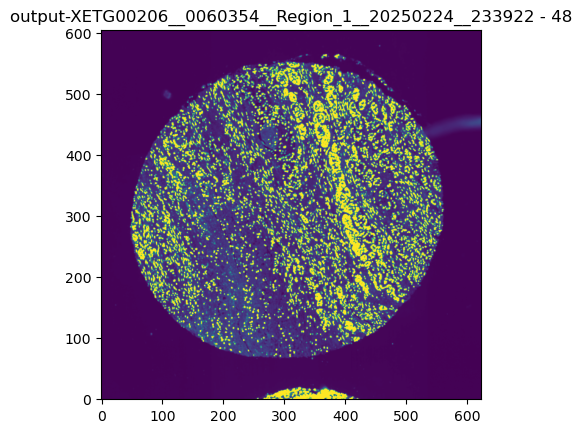

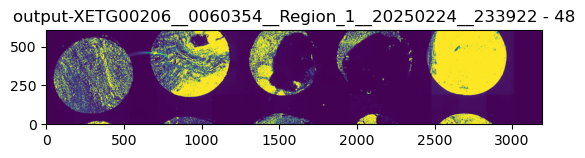

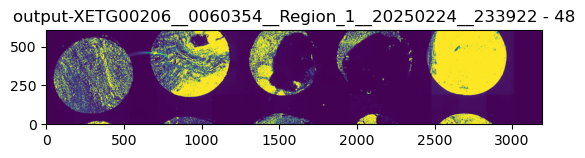

In [81]:
# If you messed up any cores or want to redo a specific core, use the recrop function instead of redoing every slide
df_idx = recrop('20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060354__Region_1__20250224__233922___48', adata, df_idx, saveimg = dir_out)

In [73]:
# Look at the final df
df_idx

,x0,x1,y0,y1,slide,core
20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060354__Region_1__20250224__233922___1,1790,2390,71,687,20250224__233848__X206_2242025_ANOGENTMA_03_04...,1
20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060354__Region_1__20250224__233922___2,2350,3013,55,687,20250224__233848__X206_2242025_ANOGENTMA_03_04...,2
20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060354__Region_1__20250224__233922___3,575,1215,79,679,20250224__233848__X206_2242025_ANOGENTMA_03_04...,3
20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060354__Region_1__20250224__233922___4,1167,1822,87,735,20250224__233848__X206_2242025_ANOGENTMA_03_04...,4
20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060354__Region_1__20250224__233922___5,2390,3029,663,1271,20250224__233848__X206_2242025_ANOGENTMA_03_04...,5
20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060354__Region_1__20250224__233922___6,1772,2398,687,1295,20250224__233848__X206_2242025_ANOGENTMA_03_04...,6
20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060354__Region_1__20250224__233922___7,88,581,759,1270,20250224__233848__X206_2242025_ANOGENTMA_03_04...,7
20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060354__Region_1__20250224__233922___8,543,1166,791,1295,20250224__233848__X206_2242025_ANOGENTMA_03_04...,8
20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060354__Region_1__20250224__233922___9,0,599,1279,1870,20250224__233848__X206_2242025_ANOGENTMA_03_04...,9
20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060354__Region_1__20250224__233922___10,1175,1798,1279,1886,20250224__233848__X206_2242025_ANOGENTMA_03_04...,10


In [ ]:
# Write the dataframe to a csv
df_idx.to_csv(f'{dir_out}/cropped_cores.csv')